In [41]:
!pip install pycountry pycountry-convert
!pip install -U kaleido

#Libraries and Datasets

In [42]:
# === Data Handling ===
import pandas as pd
import json

# === Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker  # for customizing axis ticks (e.g., gap year)
import plotly.express as px
import plotly.graph_objects as go

# === Geolocation and Region ===
import pycountry
import pycountry_convert as pc
from urllib.request import urlopen

# === Text Processing (WordCloud) ===
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from wordcloud import WordCloud


def setup_accident_df():
    # Load dataset from GitHub
    url = 'https://raw.githubusercontent.com/ppitchaporn/Aviation_Accident/refs/heads/main/Aviation_Accident.csv'
    df = pd.read_csv(url, low_memory=False)

    # Convert event dates to datetime
    df['EventDate'] = pd.to_datetime(df['EventDate'], errors='coerce')

    # Extract year from the event date
    df['Year'] = df['EventDate'].dt.year

    # Filter rows with valid injury level (fatal, serious, minor only)
    df = df[df['HighestInjuryLevel'].notna() &
            df['HighestInjuryLevel'].str.strip().str.lower().isin(['fatal', 'serious', 'minor'])]

    # Standardize and clean aircraft manufacturer names
    corrections = {
        'boeing': 'Boeing',
        'airbus': 'Airbus',
        'airbus industrie': 'Airbus',
        'mcdonell douglas': 'McDonnell Douglas',
        'mcdonnell douglas': 'McDonnell Douglas',
        'douglas': 'McDonnell Douglas',
        'embraer': 'Embraer',
        'bombardier inc': 'Bombardier',
        'bombardier': 'Bombardier',
        'lockheed': 'Lockheed'
    }

    df['Make'] = (
        df['Make']
        .str.strip()
        .str.lower()
        .replace(corrections)
        .astype('string')
        .str.capitalize()
    )

    return df

# ------------------------------------
# Utility Function: Plot Bar Chart
# ------------------------------------
def plot_bar_chart(data, x, y, title, hue=None, figsize=(15, 5)):
    plt.figure(figsize=figsize)

    # Sort by value (sum if hue exists)
    if hue:
        order = (
            data.groupby(x)[y].sum()
            .sort_values(ascending=False)
            .index.tolist()
        )
    else:
        order = data.sort_values(y, ascending=False)[x].tolist()

    # Set pastel color palette
    colors = (
        sns.color_palette('pastel', n_colors=data[hue].nunique())
        if hue else
        sns.color_palette('pastel', len(data))
    )

    # Create bar plot with sorted order
    ax = sns.barplot(data=data, x=x, y=y, hue=hue, palette=colors, order=order)

    # Title and axis styling
    ax.set_title(title, fontsize=18, fontweight='bold')
    ax.tick_params(axis='x', rotation=0, labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.grid(True, axis='y', linestyle='--', alpha=0.3)

    # Add value labels on top of bars
    max_height = data[y].max()
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', fontsize=12, padding=3)

    # Extend y-axis limit for better label spacing
    ax.set_ylim(0, max_height * 1.25)

    plt.tight_layout()
    plt.show()

def plot_subplots(data_list, titles, x_labels, y_label, hue_list=None, figsize=(15, 5)):
    import matplotlib.pyplot as plt
    import seaborn as sns

    num_charts = len(data_list)
    fig, axes = plt.subplots(1, num_charts, figsize=figsize)
    sns.set_theme(style="whitegrid")

    if num_charts == 1:
        axes = [axes]  # Ensure axes is always iterable

    for i in range(num_charts):
        data = data_list[i]
        hue = hue_list[i] if hue_list else None

        # Determine color palette
        palette = sns.color_palette('pastel', n_colors=data[hue].nunique()) if hue else sns.color_palette('pastel', len(data))

        # Create barplot
        ax = sns.barplot(data=data, x=data.columns[0], y=data.columns[-1], hue=hue, palette=palette, ax=axes[i])
        ax.set_title(titles[i], fontsize=14, fontweight='bold')
        ax.set_xlabel(x_labels[i], fontsize=12)
        ax.set_ylabel(y_label if i == 0 else "", fontsize=12)
        ax.tick_params(axis='x', rotation=0, labelsize=11)
        ax.tick_params(axis='y', labelsize=11)
        ax.grid(axis='y', linestyle='--', alpha=0.3)

        # Annotate each bar
        for container in ax.containers:
            ax.bar_label(container, fmt='%d', fontsize=10, padding=3)

        # Extend y-axis limit for spacing above bars
        max_height = data[data.columns[-1]].max()
        ax.set_ylim(0, max_height * 1.25)

    plt.tight_layout()
    plt.show()


# ------------------------------------
# Load Cleaned Data
# ------------------------------------
df = setup_accident_df()

In [43]:
# Group by year and count total accidents
accidents_per_year = df.groupby('Year').size().reset_index(name='Total Accidents')

# Sum injury counts per year
injury_sums = df.groupby('Year')[['FatalInjuryCount', 'SeriousInjuryCount', 'MinorInjuryCount']].sum().reset_index()

# Merge the two tables on Year
summary = pd.merge(accidents_per_year, injury_sums, on='Year')

# Display result
summary = summary.sort_values('Year')
summary.head()


,Year,Total Accidents,FatalInjuryCount,SeriousInjuryCount,MinorInjuryCount
0,1970,1583,1410,784,1303
1,1971,1603,1493,731,1211
2,1972,1557,1489,773,1249
3,1973,1573,1555,630,1085
4,1974,1586,1730,704,1095


#Figure 1 and 2 : Total Trends & Injury Level

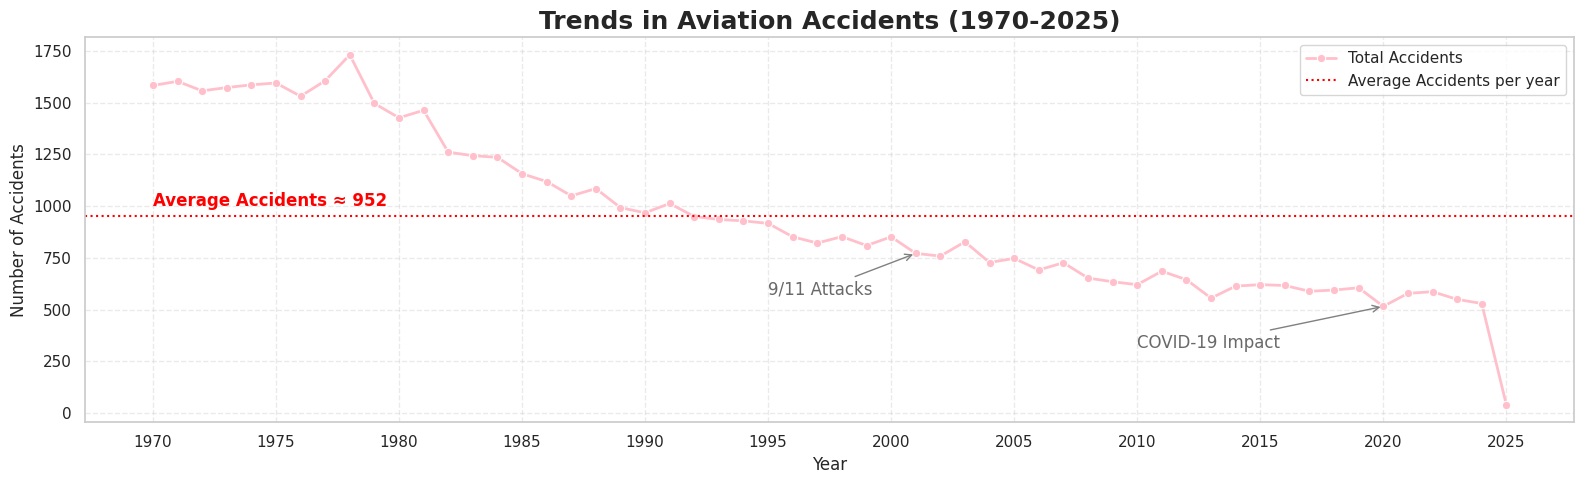

In [44]:
def plot_total_accidents(df):
    # Prepare data
    accidents_per_year = df.groupby('Year').size()
    mean_accidents = accidents_per_year.mean()

    # Create single figure
    plt.figure(figsize=(16, 5))
    sns.lineplot(x=accidents_per_year.index, y=accidents_per_year.values,
                 marker='o', linewidth=2, color='pink', label='Total Accidents')

    # Labels and Title
    plt.title('Trends in Aviation Accidents (1970-2025)', fontsize=18, fontweight='bold')
    plt.xlabel('Year')
    plt.ylabel('Number of Accidents')
    plt.grid(True, linestyle='--', alpha=0.4)

    # Set x-ticks every 5 years
    ax = plt.gca()
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))

    # Add average line (horizontal)
    plt.axhline(y=mean_accidents, color='red', linestyle=':', linewidth=1.5, label='Average Accidents per year')
    plt.text(accidents_per_year.index.min(), mean_accidents + 50,
             f'Average Accidents ≈ {mean_accidents:.0f}',
             color='red', fontsize=12, fontweight='bold')

    # Annotate 9/11
    if 2001 in accidents_per_year.index:
        plt.annotate('9/11 Attacks',
                     xy=(2001, accidents_per_year[2001]),
                     xytext=(1995, accidents_per_year[2001] - 200),
                     arrowprops=dict(arrowstyle='->', color='gray'),
                     fontsize=12, color='dimgray')

    # Annotate COVID-19
    if 2020 in accidents_per_year.index:
        plt.annotate('COVID-19 Impact',
                     xy=(2020, accidents_per_year[2020]),
                     xytext=(2010, accidents_per_year[2020] - 200),
                     arrowprops=dict(arrowstyle='->', color='gray'),
                     fontsize=12, color='dimgray')

    # Show legend and layout
    plt.legend()
    plt.tight_layout()
    #save_chart("figure_1_accidents_trend")
    plt.show()

# Run the updated function
plot_total_accidents(df)


#Figure 2: Injury counts per year


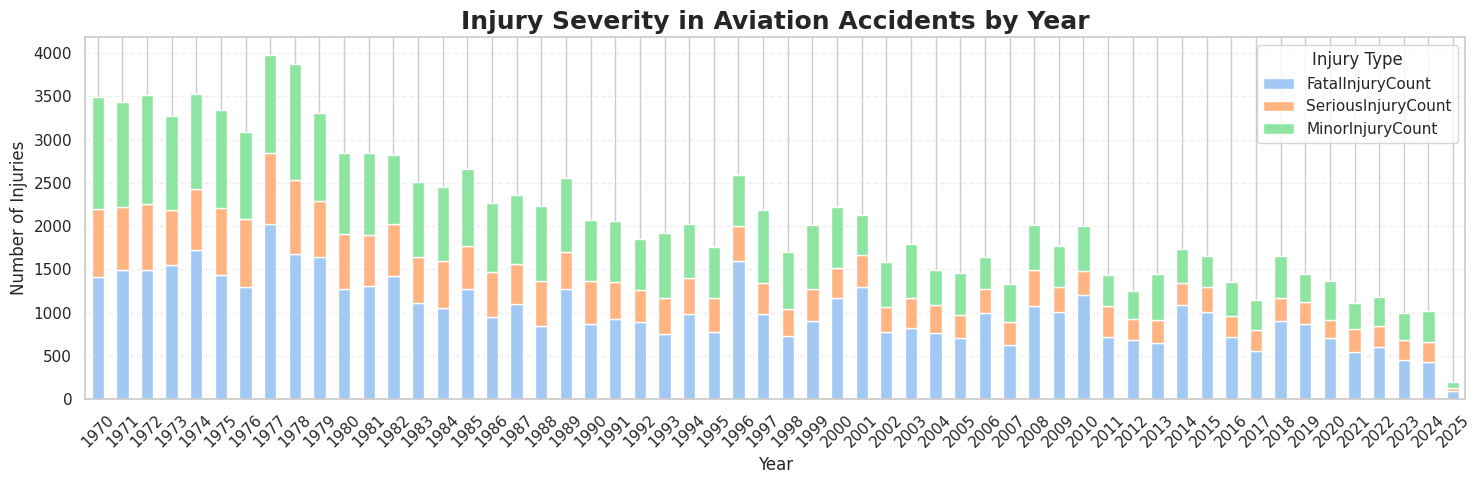

In [45]:
def plot_injury_stacked_bar(df):

    # Group by year and sum injuries
    injury_by_year = df.groupby('Year')[['FatalInjuryCount', 'SeriousInjuryCount', 'MinorInjuryCount']].sum()

    # Set pastel colors
    colors = sns.color_palette("pastel", n_colors=3)

    # Plot as stacked bar
    ax = injury_by_year.plot(kind='bar', stacked=True, figsize=(15, 5), color=colors)

    # Styling
    ax.set_title('Injury Severity in Aviation Accidents by Year', fontsize=18, fontweight='bold')
    ax.set_xlabel('Year')
    ax.set_ylabel('Number of Injuries')
    ax.grid(True, axis='y', linestyle='--', alpha=0.3)
    ax.legend(title='Injury Type')
    plt.xticks(rotation=45)
    plt.tight_layout()

    #save_chart("figure_2_injury_severity")
    plt.show()

plot_injury_stacked_bar(df)

#Figure 3: Global Distribution of Aviation Accidents by Continent

In [46]:
def get_continent(country_name):
    """Convert country name to continent name."""
    try:
        country_code = pycountry.countries.lookup(country_name).alpha_2
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        return pc.convert_continent_code_to_continent_name(continent_code)
    except:
        return 'Unclassified'

# Define function to plot geo chart by continent
def plot_geo_by_continent(df):
    """
    Plot aviation accident locations by continent with circle size representing count.
    """

    # Clean coordinates
    df_clean = df[['Latitude', 'Longitude', 'Country', 'NtsbNo']].dropna()
    df_clean = df_clean[(df_clean['Latitude'] != 0) & (df_clean['Longitude'] != 0)]

    # Add continent info
    df_clean['Continent'] = df_clean['Country'].apply(get_continent)

    # Group by Lat/Lon for map display
    grouped = df_clean.groupby(['Latitude', 'Longitude', 'Continent'])['NtsbNo'].nunique().reset_index()
    grouped.columns = ['Latitude', 'Longitude', 'Continent', 'AccidentCount']

    # Plot map
    fig = px.scatter_geo(
        grouped,
        lat='Latitude',
        lon='Longitude',
        size='AccidentCount',
        color='Continent',
        hover_name='Continent',
        size_max=15,
        projection='natural earth',
        template='plotly_white'
    )

    # Set centered bold title
    fig.update_layout(
        title={
            'text': '<b>Aviation Accidents by Continent</b>',
            'x': 0.5,
            'xanchor': 'center',
            'font': {
                'size': 20,
                'color': 'black'
                #'family': 'Arial'
            }
        },
        margin=dict(l=60, r=10, t=60, b=10)
    )

    fig.update_traces(marker=dict(opacity=0.7, line=dict(width=0)))
    #save_chart("figure_3_accidents_continent")
    fig.write_image("figure_3_accidents_continent.png", scale=2)
    fig.show()

df = setup_accident_df()
plot_geo_by_continent(df)

#Figure 4: Probable Causes of Aviation Accidents

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
<ipython-input-47-fc5a44180a5f>:42: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




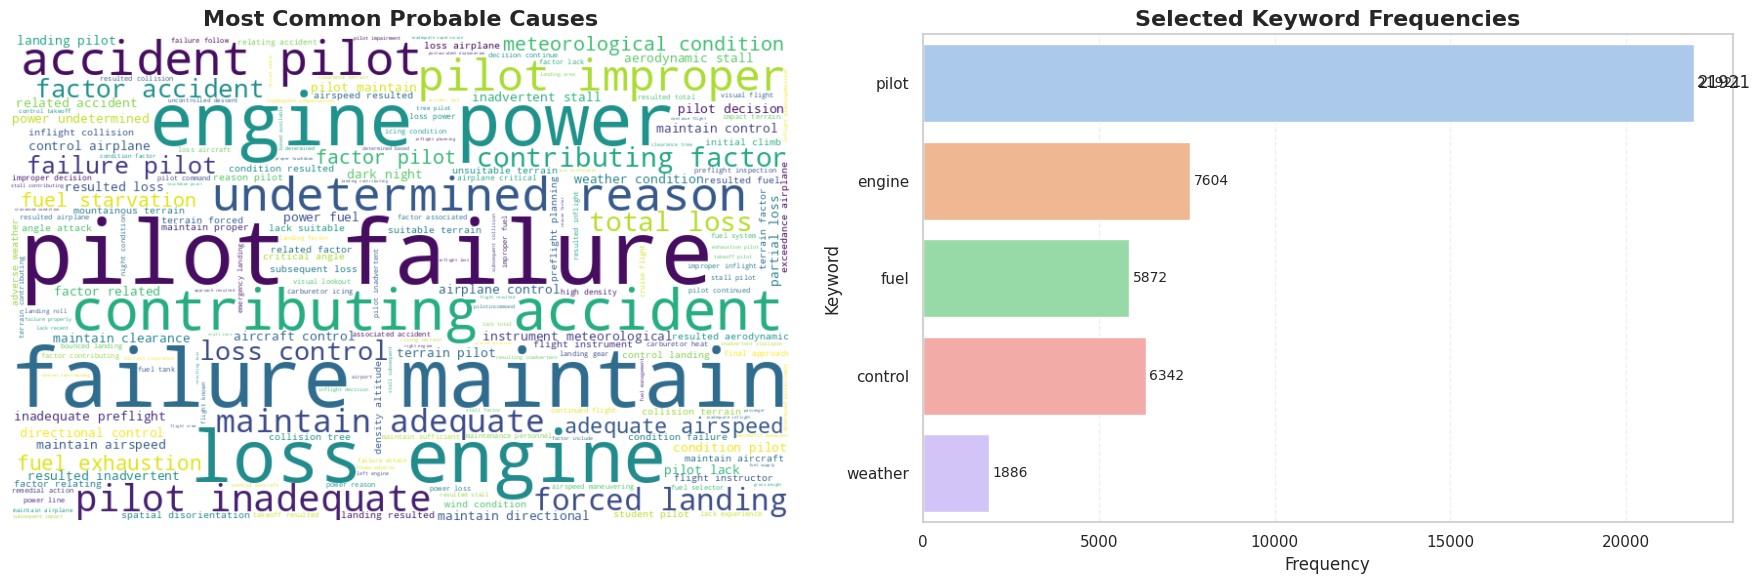

In [47]:
# Download resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Setup tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Clean and lemmatize function
def clean_and_lemmatize(text):
    text = re.sub(r'[^a-z\s]', '', str(text).lower())
    words = [
        lemmatizer.lemmatize(word)
        for word in text.split()
        if word not in stop_words and len(word) > 3
    ]
    return " ".join(words)

# Clean dataset
df = df[df['ProbableCause'].notna()].copy()
df['CleanCause'] = df['ProbableCause'].apply(clean_and_lemmatize)

# Word frequency
all_words = " ".join(df['CleanCause']).split()
word_freq = Counter(all_words)

# Define keywords to track
keywords = ['pilot', 'engine', 'fuel', 'control', 'weather']
keyword_counts = {word: word_freq.get(word, 0) for word in keywords}

# === Create side-by-side plots ===
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Left: WordCloud
wordcloud = WordCloud(width=800, height=500, background_color='white').generate(" ".join(all_words))
axes[0].imshow(wordcloud, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title("Most Common Probable Causes", fontsize=16, fontweight='bold')

# Right: Keyword Bar Chart
bars = sns.barplot(
    x=list(keyword_counts.values()),
    y=list(keyword_counts.keys()),
    palette="pastel",
    ax=axes[1]
)

# ✅ Loop through bars to show labels manually
for bar in bars.patches:
    width = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2
    axes[1].text(width + 100, y, f'{int(width)}', va='center', fontsize=10)

# Add data labels
axes[1].bar_label(bars.containers[0], fmt='%d', padding=3)

axes[1].set_title("Selected Keyword Frequencies", fontsize=16, fontweight='bold')
axes[1].set_xlabel("Frequency")
axes[1].set_ylabel("Keyword")
axes[1].grid(True, axis='x', linestyle='--', alpha=0.3)

plt.tight_layout()
#save_chart("figure_4_probable_causes")
plt.show()

#Figure 5: Top 5 Country

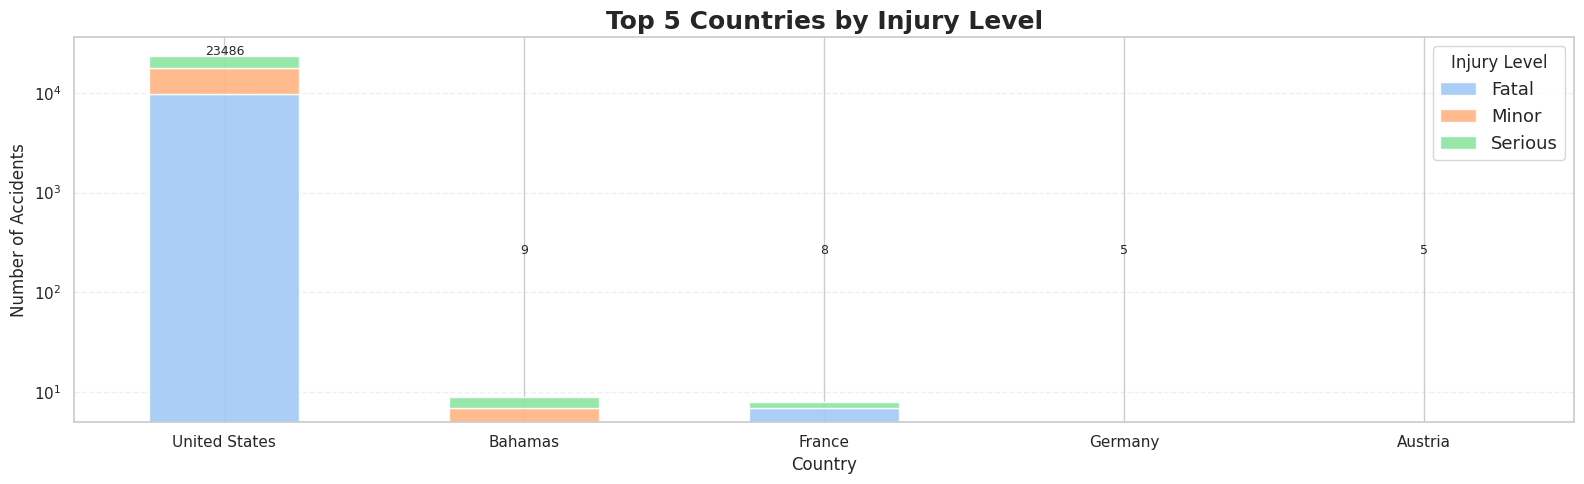

In [48]:
def plot_top_countries_(df):
    """Plot top 5 countries by injury level with data labels."""

    # Group and summarize by country and injury level
    country_summary = df.groupby(['Country', 'HighestInjuryLevel']).size().unstack(fill_value=0)
    country_summary['Total'] = country_summary.sum(axis=1)

    # Get top 5 countries by total accidents
    top5 = country_summary.sort_values('Total', ascending=False).head(5)
    top5_totals = top5['Total']
    top5 = top5.drop(columns='Total')

    # Plot stacked bar chart
    colors = sns.color_palette("pastel", n_colors=len(top5.columns))
    ax = top5.plot(kind='bar', stacked=True, figsize=(16, 5), color=colors, alpha=0.9)

    # Add total labels above each bar
    for i, total in enumerate(top5_totals):
        ax.text(i, total + max(top5_totals)*0.01, f'{int(total)}', ha='center', fontsize=9)

    ax.set_title("Top 5 Countries by Injury Level", fontsize=18, fontweight='bold')
    ax.set_xlabel("Country")
    ax.set_ylabel("Number of Accidents")
    ax.set_yscale('log')
    ax.set_xticklabels(top5.index, rotation=0)
    ax.legend(title='Injury Level', fontsize=13)
    ax.grid(True, axis='y', linestyle='--', alpha=0.3)

    plt.tight_layout()
    #save_chart("figure_5_top5_countries")
    plt.show()

plot_top_countries_(df)

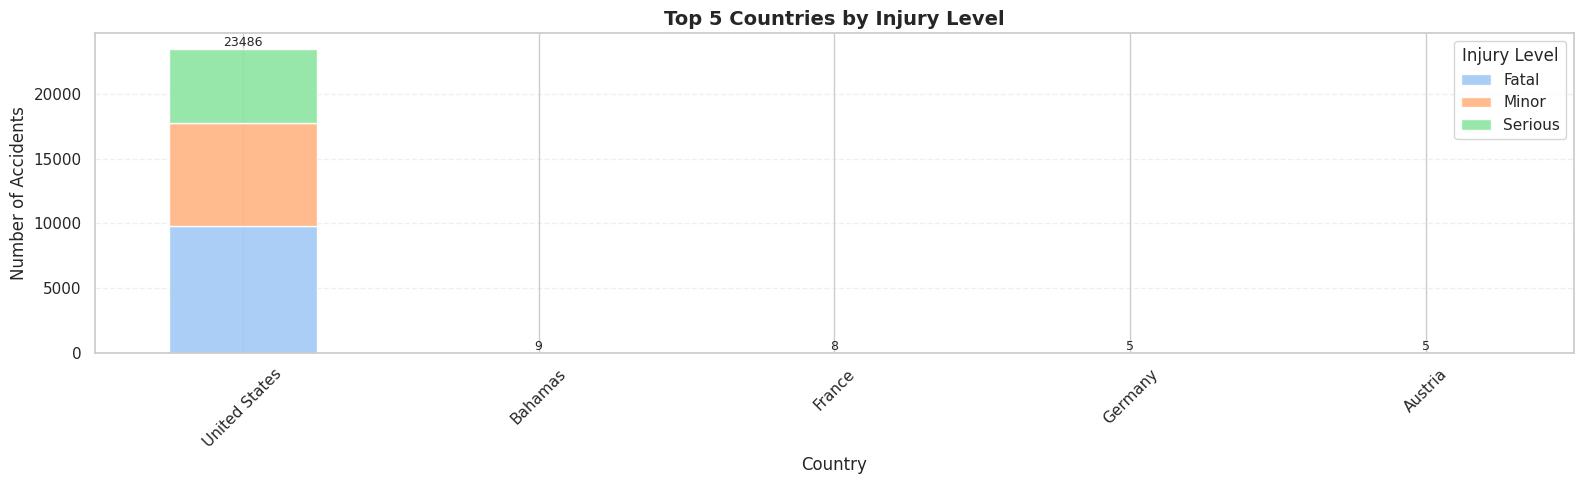

In [49]:
def plot_top_countries_(df):
    """Plot top 5 countries by injury level with data labels."""

    # Group and summarize by country and injury level
    country_summary = df.groupby(['Country', 'HighestInjuryLevel']).size().unstack(fill_value=0)
    country_summary['Total'] = country_summary.sum(axis=1)

    # Get top 5 countries by total accidents
    top5 = country_summary.sort_values('Total', ascending=False).head(5)
    top5_totals = top5['Total']
    top5 = top5.drop(columns='Total')

    # Plot stacked bar chart
    colors = sns.color_palette("pastel", n_colors=len(top5.columns))
    ax = top5.plot(kind='bar', stacked=True, figsize=(16, 5), color=colors, alpha=0.9)

    # Add total labels above each bar
    for i, total in enumerate(top5_totals):
        ax.text(i, total + max(top5_totals)*0.01, f'{int(total)}', ha='center', fontsize=9)

    ax.set_title("Top 5 Countries by Injury Level", fontsize=14, fontweight='bold')
    ax.set_xlabel("Country")
    ax.set_ylabel("Number of Accidents")
    #ax.set_yscale('log')
    ax.set_xticklabels(top5.index, rotation=45)
    ax.legend(title='Injury Level')
    ax.grid(True, axis='y', linestyle='--', alpha=0.3)

    plt.tight_layout()
    #save_chart("figure_5_top5_countries")
    plt.show()

plot_top_countries_(df)

# Figure 6: Geographic Distribution of Aviation Accidents in U.S. States

In [50]:
import requests

def plot_us_state_choropleth_with_labels(df):
    print("Plotting U.S. State Choropleth with Labels")

    # Step 1: Count unique aviation accidents per state
    state_counts = df.groupby('State')['NtsbNo'].nunique().reset_index()
    state_counts.columns = ['State', 'AccidentCount']
    state_counts = state_counts[state_counts['State'].notna()]

    # Step 2: Load state centroids (lat/lon) from external JSON
    centroid_url = "https://gist.githubusercontent.com/claraj/3880cd48b3d8cb3a7f900aeb30b18fdd/raw/e9b5ca44aaed5de3107c10fe61a7dd248edfc1c9/formatted_with_suggested_zoom.json"
    centroid_data = requests.get(centroid_url).json()

    # Step 3: Convert to dictionary for fast lookup
    state_centroids = {entry['name']: (entry['lat'], entry['lon']) for entry in centroid_data}

    # Step 4: Map coordinates to states
    state_counts['Lat'] = state_counts['State'].map(lambda x: state_centroids.get(x, [None, None])[0])
    state_counts['Lon'] = state_counts['State'].map(lambda x: state_centroids.get(x, [None, None])[1])
    state_counts = state_counts.dropna(subset=['Lat', 'Lon'])

    # Step 5: Load U.S. state shapes for the choropleth map
    # https://plotly.com/python/choropleth-maps/

    with urlopen('https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json') as response:
        geojson = json.load(response)

    # Step 6: Plot state-level accident counts using Plotly choropleth
    fig = px.choropleth(
        state_counts,
        geojson=geojson,
        locations='State',
        featureidkey="properties.name",
        color='AccidentCount',
        color_continuous_scale='Viridis',
        scope="usa",
        labels={'AccidentCount': 'Total Accidents'},
        title="Geographic Distribution of Aviation Accidents in the U.S. (1970–2025)"
    )

    # Step 7: Add accident count labels using centroid coordinates
    fig.add_trace(go.Scattergeo(
        locationmode='USA-states',
        lon=state_counts['Lon'],
        lat=state_counts['Lat'],
        text=state_counts['State'] + "<br>" + state_counts['AccidentCount'].astype(str),
        mode='text',
        showlegend=False,
        textfont=dict(size=10, color='black')
    ))

    # Step 8: Layout settings
    fig.update_geos(fitbounds="locations", visible=False)
    fig.update_layout(margin={"r": 0, "t": 50, "l": 0, "b": 0})

    # Show plot
    fig.show()

plot_us_state_choropleth_with_labels(df)

Plotting U.S. State Choropleth with Labels


# Figure 7: Top 5 U.S. States by Damage Types

Preparing aircraft damage data...


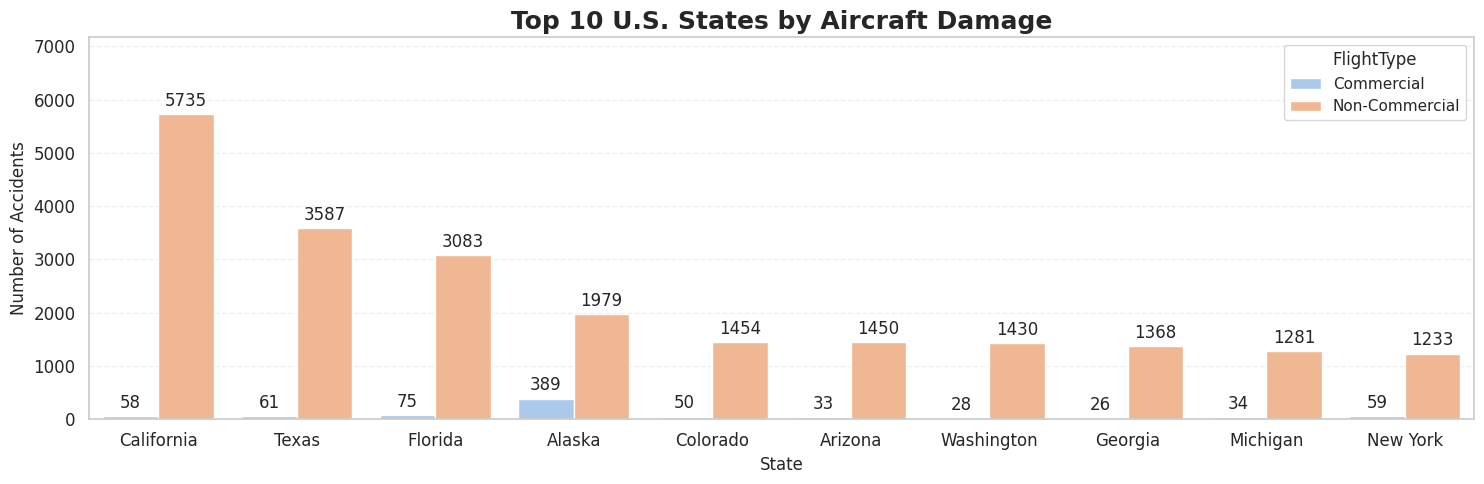

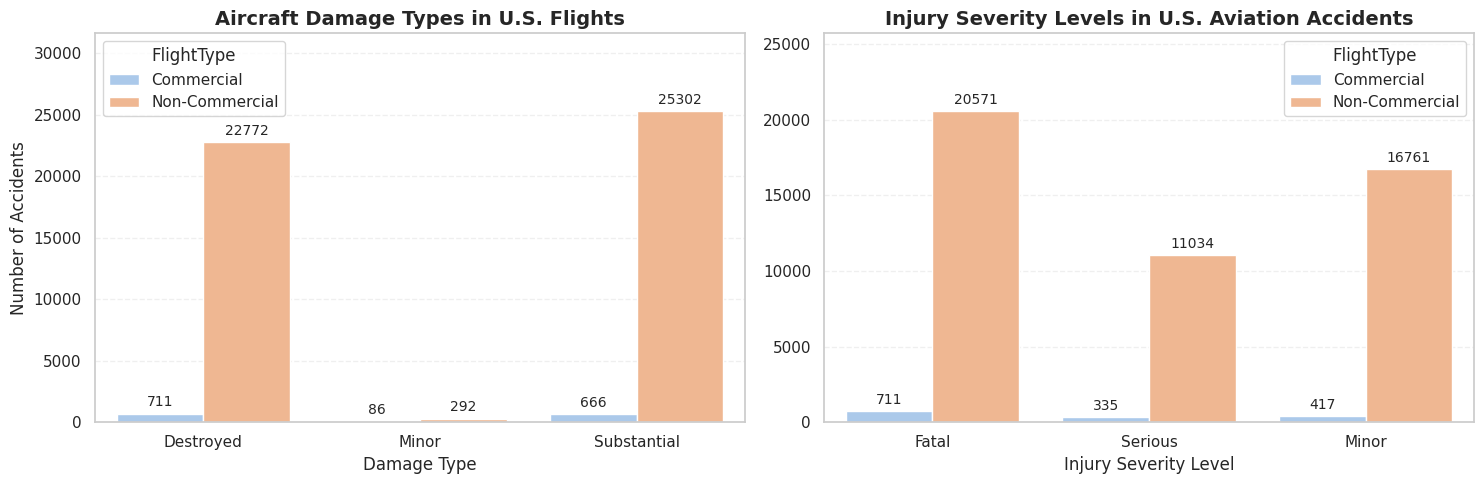

In [51]:
# ------------------------------------
# Aircraft Damage Analysis
# ------------------------------------
def classify_flight_type(df):
    commercial_keywords = ['121', '135', '129', '125']
    df = df.copy()
    df['FlightType'] = df['FAR'].fillna('').apply(
        lambda x: 'Commercial' if any(k in x for k in commercial_keywords) else 'Non-Commercial'
    )
    return df

def prepare_damage_data(df):
    us_df = df[df['Country'] == 'United States']
    damage_df = (
        us_df[['AirCraftDamage', 'FlightType', 'Year', 'State', 'HighestInjuryLevel']]
        .dropna(subset=['AirCraftDamage', 'Year', 'State', 'HighestInjuryLevel'])
        .assign(DamageType=lambda d: d['AirCraftDamage'].str.split(','))
        .explode('DamageType')
        .assign(DamageType=lambda d: d['DamageType'].str.strip())
    )
    return damage_df[~damage_df['DamageType'].isin(['', 'None', 'Unknown'])]

def plot_damage_by_state(data):
    top_states = data['State'].value_counts().head(10).index
    filtered = data[data['State'].isin(top_states)]
    summary = (
        filtered.groupby(['State', 'FlightType'], observed=True)
        .size()
        .reset_index(name='Number of Accidents')
    )
    plot_bar_chart(
        data=summary,
        x='State',
        y='Number of Accidents',
        hue='FlightType',
        title='Top 10 U.S. States by Aircraft Damage'
    )

def plot_damage_type_and_injury_severity(data):

    # --- Chart 1: Aircraft Damage Types by Flight Type ---
    damage_summary = (
        data.groupby(['DamageType', 'FlightType'], observed=True)
        .size()
        .reset_index(name='Count')
    )

    # --- Chart 2: Injury Severity Levels by Flight Type ---
    valid_levels = ['Fatal', 'Serious', 'Minor']
    filtered = data[data['HighestInjuryLevel'].str.strip().str.capitalize().isin(valid_levels)].copy()
    filtered['HighestInjuryLevel'] = filtered['HighestInjuryLevel'].str.strip().str.capitalize()
    injury_summary = (
        filtered.groupby(['HighestInjuryLevel', 'FlightType'], observed=True)
        .size()
        .reset_index(name='Count')
    )
    injury_summary['HighestInjuryLevel'] = pd.Categorical(
        injury_summary['HighestInjuryLevel'], categories=valid_levels, ordered=True
    )

    # --- Call generic subplot function ---
    plot_subplots(
        data_list=[damage_summary, injury_summary],
        titles=[
            'Aircraft Damage Types in U.S. Flights',
            'Injury Severity Levels in U.S. Aviation Accidents'
        ],
        x_labels=['Damage Type', 'Injury Severity Level'],
        y_label='Number of Accidents',
        hue_list=['FlightType', 'FlightType']
    )


def plot_aircraft_damage_by_commercial_type(df):
    print("Preparing aircraft damage data...")
    df = classify_flight_type(df)
    damage_data = prepare_damage_data(df)
    plot_damage_by_state(damage_data)
    plot_damage_type_and_injury_severity(damage_data)

# ------------------------------------
# Execute
# ------------------------------------
df = setup_accident_df()
plot_aircraft_damage_by_commercial_type(df)

# Figure 8: U.S. Aviation Accidents by Weather Condition

<ipython-input-42-15832a5a87c1>:90: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




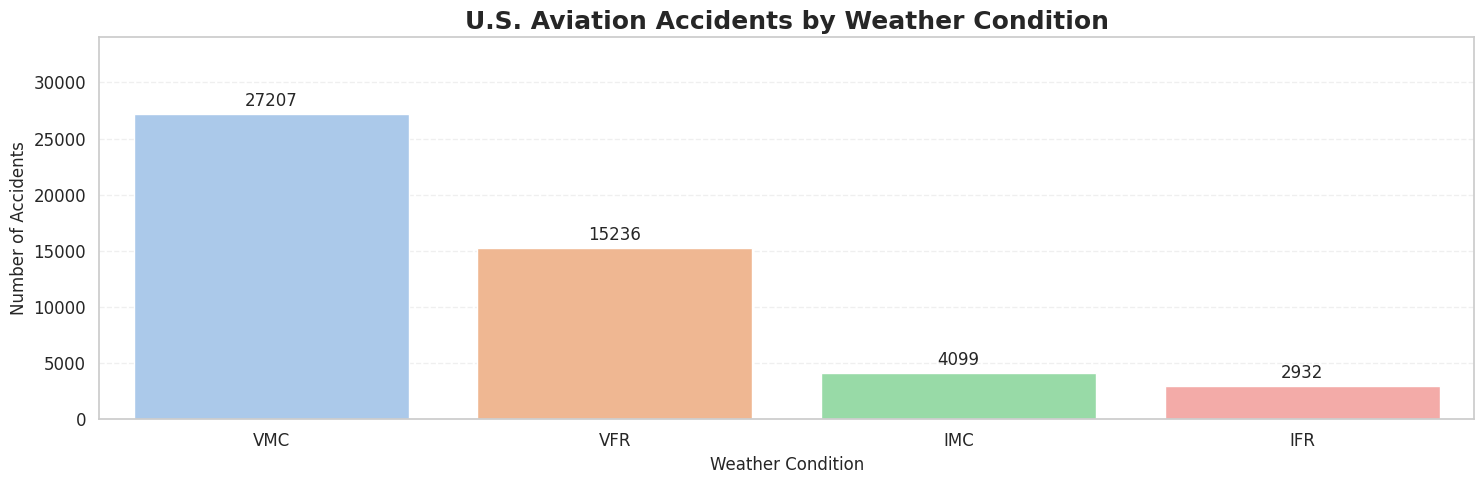

In [52]:
def plot_weather_conditions(df):
    # Filter U.S. data and clean WeatherCondition column
    us_df = df[df['Country'] == 'United States'].copy()
    us_df = us_df[us_df['WeatherCondition'].notna()]
    us_df['WeatherCondition'] = us_df['WeatherCondition'].str.strip()
    us_df = us_df[~us_df['WeatherCondition'].isin(['', 'Unknown', 'UNK'])]

    # Count weather condition occurrences
    summary = us_df['WeatherCondition'].value_counts().reset_index()
    summary.columns = ['Weather Condition', 'Number of Accidents']

    # Plot with improved labeling
    plot_bar_chart(
        data=summary,
        x='Weather Condition',
        y='Number of Accidents',
        title='U.S. Aviation Accidents by Weather Condition'
    )

# Run the function
plot_weather_conditions(df)


# Figure 9: Top 5 Aircraft Manufacturers in Pilot-Related Accidents (US Commercial Flights)

<ipython-input-42-15832a5a87c1>:90: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




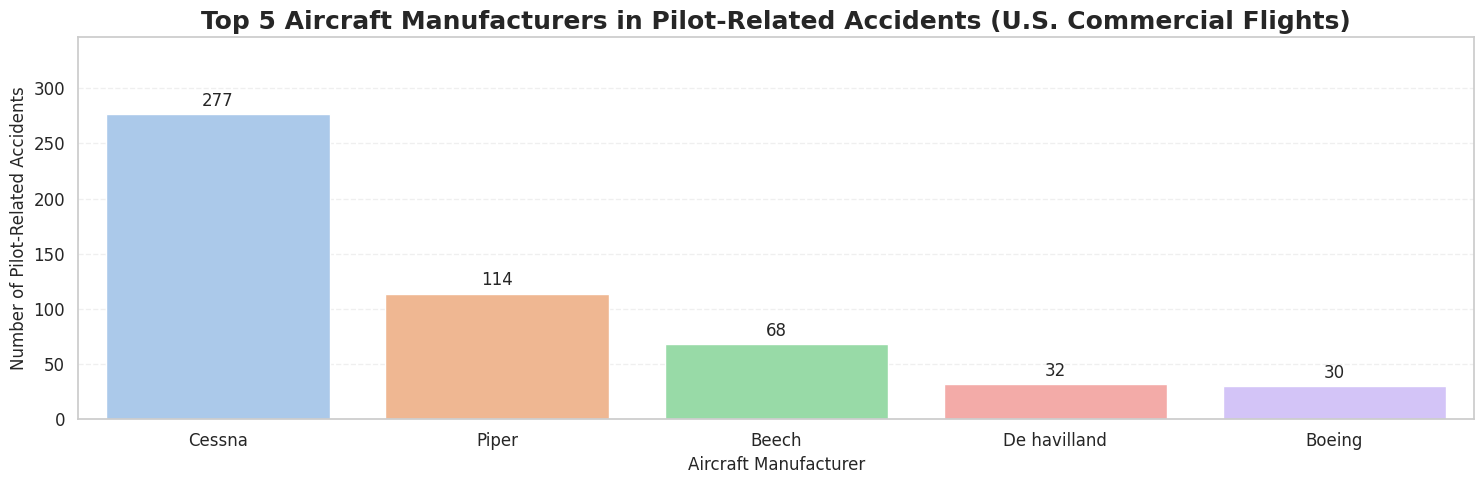

In [53]:
def plot_pilot_related_by_make(df):

    # Step 1: Classify commercial flights
    commercial_keywords = ['121', '135', '129', '125']
    df['FlightType'] = df['FAR'].fillna('').apply(
    lambda x: 'Commercial' if any(k in x for k in commercial_keywords) else 'Non-Commercial'
    )

    # Step 2: Filter only U.S. commercial flights with Make and ProbableCause
    filtered_df = df[
        (df['Country'] == 'United States') &
        (df['FlightType'] == 'Commercial') &
        df['Make'].notna() &
        df['ProbableCause'].notna()
    ].copy()

    # Step 3: Clean text
    filtered_df['Make'] = filtered_df['Make'].str.strip()
    filtered_df['ProbableCause'] = filtered_df['ProbableCause'].str.lower()

    # Step 4: Filter only accidents with the word 'pilot'
    pilot_df = filtered_df[filtered_df['ProbableCause'].str.contains('pilot')]

    # Step 5: Count top 5 aircraft manufacturers
    top_makes = pilot_df['Make'].value_counts().head(5).reset_index()
    top_makes.columns = ['Aircraft Manufacturer', 'Number of Pilot-Related Accidents']

    # Step 6: Plot
    plot_bar_chart(
        data=top_makes,
        x='Aircraft Manufacturer',
        y='Number of Pilot-Related Accidents',
        title='Top 5 Aircraft Manufacturers in Pilot-Related Accidents (U.S. Commercial Flights)'
    )


plot_pilot_related_by_make(df)

# Figure 10: Top 5 Airports with Most Takeoff and Landing Accidents (Commercial Flights)

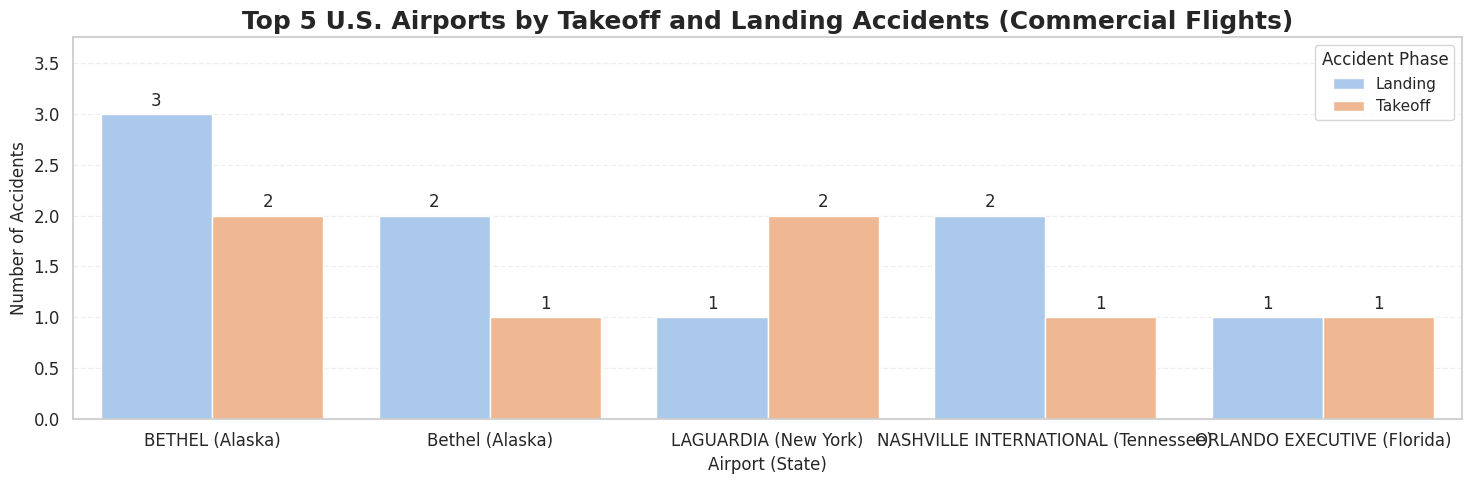

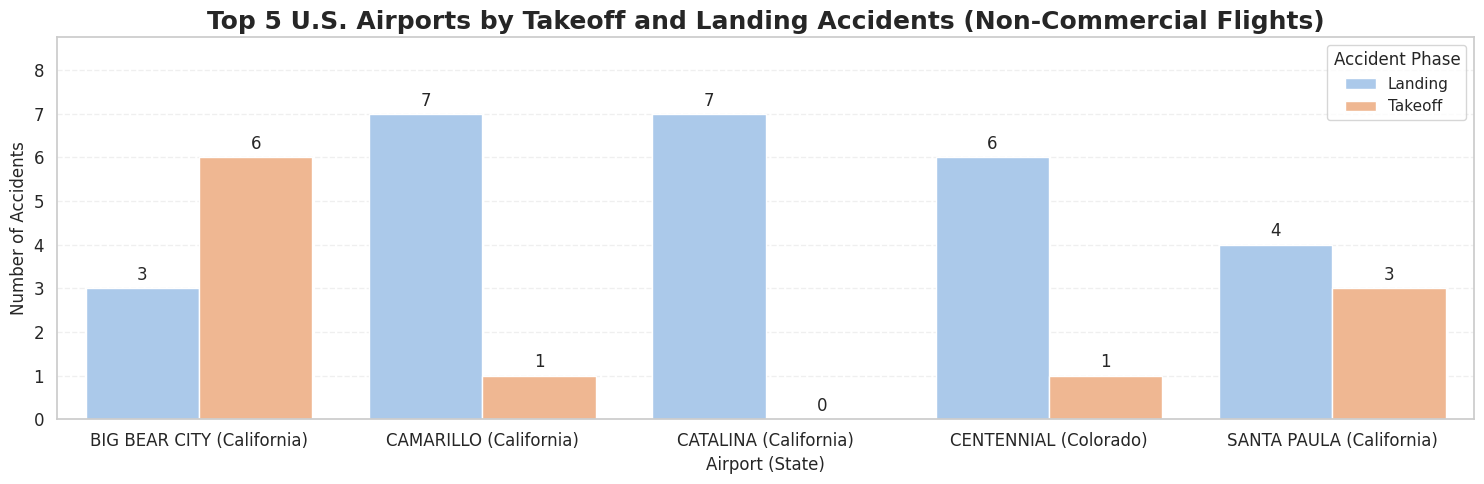

In [54]:
def plot_top5_airports_takeoff_vs_landing(df):

    # Step 1: Classify commercial flights
    commercial_keywords = ['121', '135', '129', '125']
    df['FlightType'] = df['FAR'].fillna('').apply(
    lambda x: 'Commercial' if any(k in x for k in commercial_keywords) else 'Non-Commercial'
    )

    # Step 2: Filter for valid U.S. flights
    df = df[
        (df['Country'] == 'United States') &
        df['AirportName'].notna() &
        df['State'].notna() &
        df['ProbableCause'].notna()
    ].copy()

    # Step 3: Clean text fields and create airport label
    df['AirportName'] = df['AirportName'].str.strip()
    df['State'] = df['State'].str.strip()
    df['ProbableCause'] = df['ProbableCause'].str.lower()
    df['Airport (State)'] = df['AirportName'] + ' (' + df['State'] + ')'

    # Step 4: Classify accident phase
    def classify_phase(text):
        if any(word in text for word in ['takeoff', 'take-off', 'depart', 'departure']):
            return 'Takeoff'
        elif any(word in text for word in ['land', 'landing', 'approach', 'flare']):
            return 'Landing'
        return None

    df['Accident Phase'] = df['ProbableCause'].apply(classify_phase)
    df = df[df['Accident Phase'].notna()]

    # Step 5: Plot for each FlightType
    for flight_type in ['Commercial', 'Non-Commercial']:
        flight_df = df[df['FlightType'] == flight_type]
        phase_counts = flight_df.groupby(['Airport (State)', 'Accident Phase']).size().unstack(fill_value=0)
        phase_counts['Total Accidents'] = phase_counts.sum(axis=1)

        top5 = phase_counts.sort_values('Total Accidents', ascending=False).head(5).drop(columns='Total Accidents')
        top5_long = top5.reset_index().melt(
            id_vars='Airport (State)',
            var_name='Accident Phase',
            value_name='Number of Accidents'
        )

        plot_bar_chart(
            data=top5_long,
            x='Airport (State)',
            y='Number of Accidents',
            hue='Accident Phase',
            title=f'Top 5 U.S. Airports by Takeoff and Landing Accidents ({flight_type} Flights)'
        )

plot_top5_airports_takeoff_vs_landing(df)

# Figure 11: U.S. Commercial Flight Trends

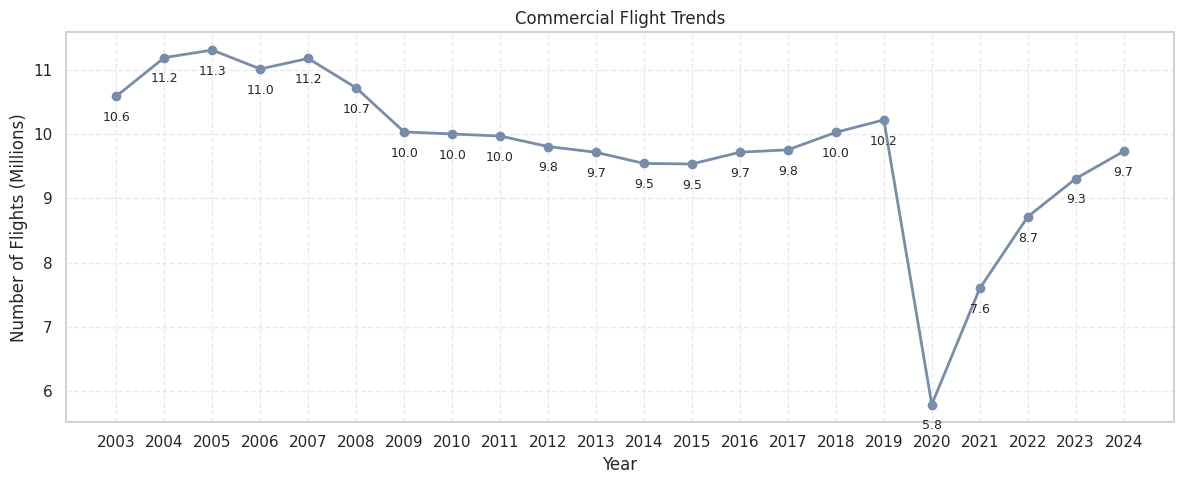

In [55]:
def setup_flights_df():
    url = 'https://raw.githubusercontent.com/ppitchaporn/Aviation_Accident/refs/heads/main/Commercial_Flight_Data.csv'
    df = pd.read_csv(url)
    df['TOTAL'] = df['TOTAL'].replace(',','', regex=True).astype(int)
    df['Year'] = df['Year'].astype(str)
    # df = df[['Year', 'TOTAL']].groupby('Year').sum()
    flight_df = df.iloc[1:]
    return flight_df

# Flights Trend
flight_df = setup_flights_df()
flight_df['TOTAL'] = flight_df['TOTAL'].replace(',','', regex=True).astype(int)
flight_df['Year'] = flight_df['Year'].astype(str)
flight_df = flight_df.iloc[1:]

# Aggregate by year and convert to millions
flight_year = flight_df.groupby('Year')['TOTAL'].sum().reset_index()
flight_year['TOTAL'] = flight_year['TOTAL'] / 1_000_000
flight_year = flight_year.iloc[1:]

# Plotting
plt.figure(figsize=(12, 5))
plt.plot(flight_year['Year'], flight_year['TOTAL'], marker='o', linewidth=2, color='#778da9')
plt.title('Commercial Flight Trends')
plt.xlabel('Year')
plt.ylabel('Number of Flights (Millions)')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
for x, y in zip(flight_year['Year'], flight_year['TOTAL']):
    plt.annotate(
        f"{y:.1f}",            # text
        xy=(x, y),             # point to label
        xytext=(0, -20),         # offset: 0 pts horizontally, +5 pts vertically
        textcoords="offset points",
        ha='center',           # horizontal alignment
        va='bottom',           # vertical alignment
        fontsize=9
    )

plt.show()

# Figure 12: U.S. Passengers Trends

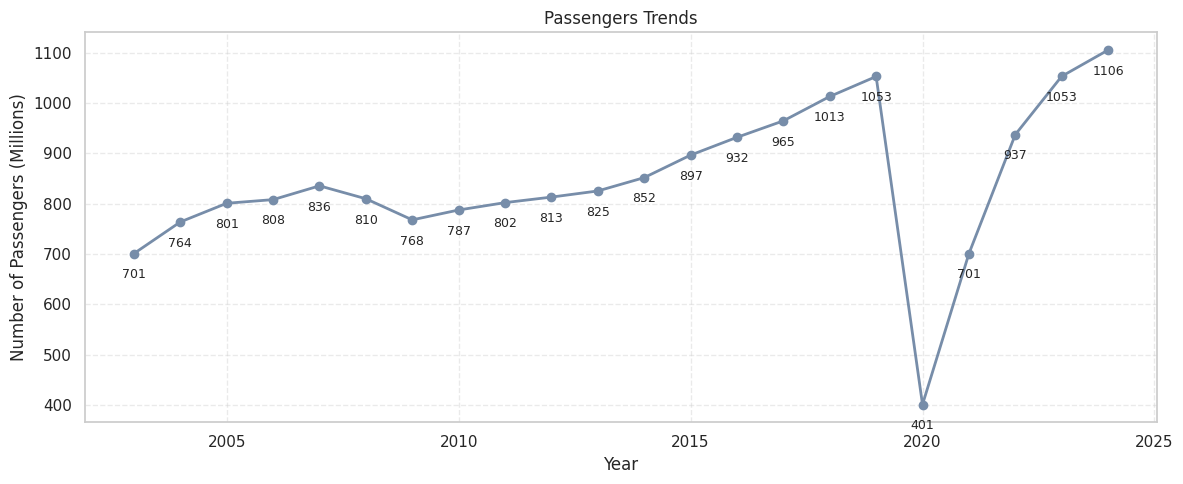

In [56]:
# Get Data
url2 = 'https://raw.githubusercontent.com/ppitchaporn/Aviation_Accident/refs/heads/main/All_Passenger.csv'
passengers_df = pd.read_csv(url2)
passengers_df['TOTAL'] = passengers_df['TOTAL'].replace(',','', regex=True).astype(int)
passengers_df['Year'] = passengers_df['Year'].astype(int)
passengers_df = passengers_df.iloc[1:]
passengers_df.head()

# Group by Year
passengers_df = passengers_df.groupby('Year')[['TOTAL']].sum().iloc[1:].reset_index()
passengers_df.rename(columns={'TOTAL': 'total_passengers'}, inplace=True)
# passengers_df['Year'] = passengers_df['Year'].astype('string')
passengers_df['total_passengers'] = (passengers_df['total_passengers'] / 1_000_000).round(2)

# Plotting
plt.figure(figsize=(12, 5))
plt.plot(passengers_df.Year, passengers_df.total_passengers, marker='o', linewidth=2, color='#778da9')
plt.title('Passengers Trends')
plt.xlabel('Year')
plt.ylabel('Number of Passengers (Millions)')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
for x, y in zip(passengers_df.Year, passengers_df.total_passengers):
    plt.annotate(
        f"{y:.0f}",            # text
        xy=(x, y),             # point to label
        xytext=(0, -20),         # offset: 0 pts horizontally, +5 pts vertically
        textcoords="offset points",
        ha='center',           # horizontal alignment
        va='bottom',           # vertical alignment
        fontsize=9
    )

plt.show()

# Figure 13: Fatal Accidents in Commercial and Non-Commercial Aviation (Moving Average)

<class 'pandas.core.frame.DataFrame'>
Index: 52 entries, 4 to 55
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Year              52 non-null     string 
 1   FatalInjuryCount  52 non-null     int64  
 2   Fatal_5MA         52 non-null     float64
dtypes: float64(1), int64(1), string(1)
memory usage: 1.6 KB


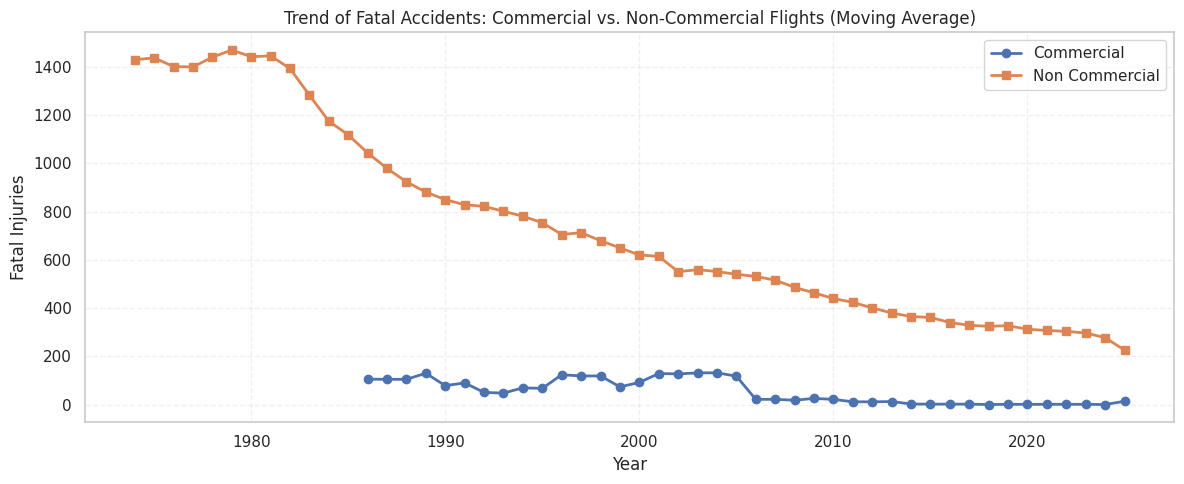

In [57]:
# Get Data
accident_df = setup_accident_df()
# Fliter only commercial flights & U.S.
accident_df = accident_df[accident_df['FAR'].str.contains('121', na=False)]
# accident_df = accident_df[accident_df['Country'] == 'United States']
accident_df['Year'] = accident_df['Year'].astype('string')

# Group by
fatal_df = accident_df[['Year', 'FatalInjuryCount']].groupby('Year').sum().reset_index()
fatal_df['Fatal_5MA'] = fatal_df['FatalInjuryCount'].rolling(window=5).mean()
fatal_df = fatal_df[fatal_df['Fatal_5MA'].notna()]
fatal_df.head()

# Get Data
acc_n_df = setup_accident_df()

# Fliter only commercial flights & U.S.
acc_n_df = acc_n_df[~acc_n_df['FAR'].str.contains('121', na=False)]
acc_n_df = acc_n_df[acc_n_df['Country'] == 'United States']
acc_n_df['Year'] = acc_n_df['Year'].astype('string')
# acc_n_df.head()

# Group by
fatal_nc_df = acc_n_df[['Year', 'FatalInjuryCount']].groupby('Year').sum().reset_index()
fatal_nc_df['Fatal_5MA'] = fatal_nc_df['FatalInjuryCount'].rolling(window=5).mean()
fatal_nc_df = fatal_nc_df[fatal_nc_df['Fatal_5MA'].notna()]
fatal_nc_df.info()

# Sorting
fatal_df['Year'] = fatal_df['Year'].astype(int)
fatal_nc_df['Year'] = fatal_nc_df['Year'].astype(int)

# Plotting Commercial & Non-Commercial
plt.figure(figsize=(12, 5))
plt.plot(fatal_df['Year'], fatal_df['Fatal_5MA'], marker='o', label='Commercial', linewidth=2)
plt.plot(fatal_nc_df['Year'], fatal_nc_df['Fatal_5MA'], marker='s', label='Non Commercial', linewidth=2)

# Plotting
plt.title('Trend of Fatal Accidents: Commercial vs. Non-Commercial Flights (Moving Average)')
plt.xlabel('Year')
plt.ylabel('Fatal Injuries')
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()

plt.show()

# Figure 14: Fatal injury rate for commercial flights in the US

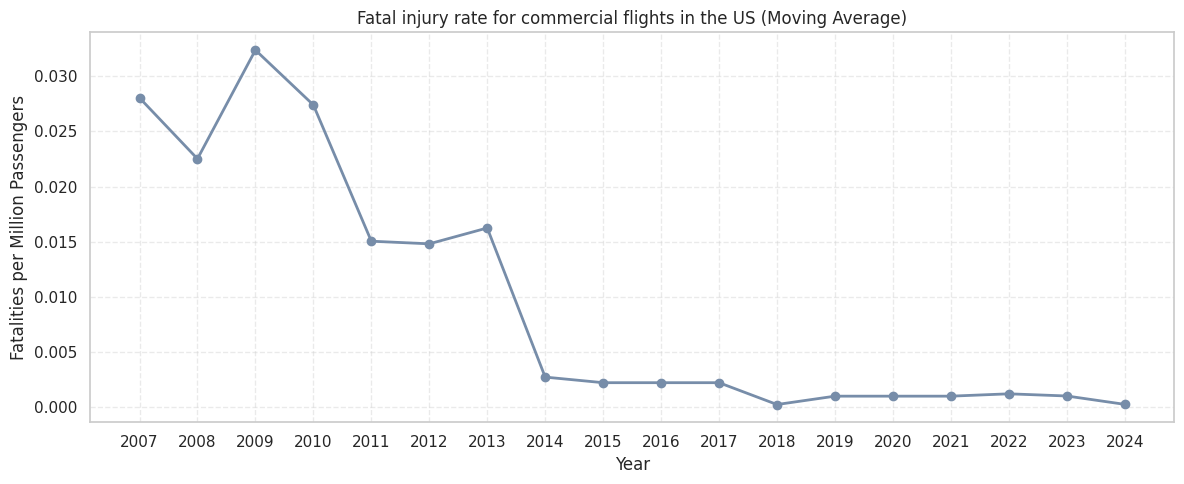

In [58]:
# Merge Table
fatal_passenger = pd.merge(passengers_df, fatal_df, on='Year', how='inner')
fatal_passenger = fatal_passenger[['Year', 'total_passengers', 'FatalInjuryCount']]

# Calculate Fatal Rate
fatal_passenger['fatal_rate'] = fatal_passenger['FatalInjuryCount'] / fatal_passenger['total_passengers']

# Calculate Fatal Rate 5 Years Moving Average
fatal_passenger['fatal_rate_5MA'] = fatal_passenger['fatal_rate'].rolling(window=5).mean()
fatal_passenger = fatal_passenger[fatal_passenger['fatal_rate_5MA'].notna()]
fatal_passenger['Year'] = fatal_passenger['Year'].astype(int)
fatal_passenger

# Plotting
plt.figure(figsize=(12, 5))
plt.plot(fatal_passenger['Year'], fatal_passenger['fatal_rate_5MA'], marker='o', linewidth=2, color='#778da9')
plt.title('Fatal injury rate for commercial flights in the US (Moving Average)')
plt.xlabel('Year')
plt.ylabel('Fatalities per Million Passengers')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()

# Format x-axis
plt.xticks(fatal_passenger['Year'], [f'{int(y)}' for y in fatal_passenger['Year']])
plt.show()

